In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
%matplotlib inline  
from IPython.display import FileLink, FileLinks, SVG

import glob
from scipy import stats
import numpy as np

In [2]:
df = pd.read_csv('./pilot.csv')
df['logs'] = df['logs'].map(lambda x: json.loads(x) if not pd.isnull(x) else pd.NA)

df.loc[df['participant_id'].isna(),'participant_id'] = 'test'
df['__INDEX__'] = df['__INDEX__'].map(json.loads)

df.loc[df['participant_id'] == 'arnav','participant_id'] = "1"
df.loc[df['participant_id'] == 'karthik','participant_id'] = "2"
df.loc[df['participant_id'] == 'majeed','participant_id'] = "3"
df = df[~df.participant_id.isin(["bdog","9jsrk50xr9c-default","test","p6p94dhwo5-default","blaine", "unknown", "1", "2", "3"])].copy()

def find_start(x):
    if type(x) != list:
        return pd.NA
    
    for log in x:
        if log['type'] == 'START':
            return log['timestamp']
    
    return pd.NA

def find_end(x):
    if type(x) != list:
        return pd.NA
    for log in x:
        if log['type'] == 'END':
            return log['timestamp']
    
    return pd.NA


def extract_metadata(x):
#     print(pd.Series(json.loads(x['metadata'])))
    d = json.loads(x['metadata'])
    if 'participant_id' in d:
        del d['participant_id']
    return pd.Series(d)
   

In [3]:
# TODO: I accidentally made it so that if there is no menu it is baseline. If there is a menu and it is baseline then it is something else -_-

In [4]:
def fix_menu_labels(row):
    if row['task'] == 'DivergentTest':
        if row['version'] == 'prolific-pilot@2':
            if row['menu'] == 'baseline':
                row['menu'] = json.loads(row['order'])[row['__INDEX__'][0] - 4]
            elif pd.isna(row['menu']):
                row['menu'] = 'baseline'
    return row
df = df.apply(fix_menu_labels, axis=1)

In [5]:
# df[df['task'] == 'DivergentTest'].groupby(['participant_id', 'menu']).count()

In [6]:
 

df['start'] = df['logs'].map(find_start)
df['end'] = df['logs'].map(find_end)
# df = df.apply(find_random_pid, axis=1)
df = pd.concat([df, df.apply(extract_metadata, axis=1)], axis=1)


df['menu'] = df.menu.astype("category")
df.menu = df.menu.cat.reorder_categories(['ToolPalette', 'KeyboardShortcutsWithCheatsheet', 'MarkingMenu'])
df.menu = df.menu.cat.rename_categories({'KeyboardShortcutsWithCheatsheet' : 'Keyboard Shortcuts', 'MarkingMenu' : 'Marking Menu', 'ToolPalette' : 'Tool Palette'})

In [7]:
def rename_participants(x):
#     print(x['participant_id'])
#     print(pd.isna(x['participant_id']))
    
    if pd.isna(x['participant_id']) or x['participant_id'] == 'unknown':
        x['participant_id'] = x['participant']
    return x
df = df.apply(rename_participants, axis=1)

In [8]:
demographics = pd.concat([pd.read_csv(p) for p in glob.glob('../data/prolific_export*.csv')])
demographics['participant_id'] = demographics['Participant id']

df = df.merge(demographics, on='participant_id', how="left")


ValueError: No objects to concatenate

In [ ]:
# df['Age'] = df['Age'].replace('DATA_EXPIRED', pd.NA)
df['Age'] = pd.to_numeric(df['Age'],errors='coerce')
df['Age'].unique()

In [ ]:
gdf = df.groupby(['participant_id']).agg({'start' : 'min', 'end' : 'max'}).reset_index()
gdf['duration'] = gdf['end'] - gdf['start']
gdf['duration_minutes'] = gdf['duration'] / 1000 / 60

In [ ]:
sns.histplot(data=gdf, x="duration_minutes")

In [ ]:
gdf[(np.abs(stats.zscore(gdf['duration_minutes'])) >= 3)]

In [ ]:
participants = df.drop_duplicates(subset='participant_id')

In [ ]:
sns.histplot(data=participants, x="Age")

In [ ]:
participants[["Age"]].describe()

In [ ]:
sns.countplot(data=participants, x="Sex")

In [ ]:
sns.countplot(data=participants, x="order")

In [ ]:
demographics.columns

In [ ]:
df.menu.unique()

# Dataframe Creation

## Selection

In [14]:
selection = df[df['task'] == 'CommandSelection'].copy()

def extract_selection(row):
    errors = 0
    start = None
    end = None
    print(row)
#     if pd.isna(row['logs']):
#         return pd.NA
    for log in row['logs']:
        if log['type'] == 'WRONG_COMMAND':
            errors += 1
        if log['type'] == 'START':
            start = log['timestamp']
        if log['type'] == 'END':
            end = log['timestamp']
    row['errors'] = errors
    row['has_error'] = errors > 0
    row['duration_milliseconds'] = end - start
    row['duration_minutes'] = row['duration_milliseconds'] / 1000 / 60
    return row

selection['trial'] = selection['__INDEX__'].map(lambda x: x[2])
selection['trial_total'] = selection['__INDEX__'].map(lambda x: x[0] * x[1])

selection = selection[['participant_id', '__INDEX__', 'logs', 'command', 'trial','trial_total', 'menu']]

selection = selection.apply(extract_selection, axis=1)
selection['menu'] = selection.menu.astype("category")

participant_id                                         DevIncognito
__INDEX__                                                 [3, 1, 0]
logs              [{'type': 'START', 'timestamp': 1679010660479}...
command                                                      Delete
trial                                                             0
trial_total                                                       3
menu                                                   Tool Palette
Name: 4, dtype: object
participant_id                                         DevIncognito
__INDEX__                                                 [3, 1, 1]
logs              [{'type': 'START', 'timestamp': 1679010663036}...
command                                                     No fill
trial                                                             1
trial_total                                                       3
menu                                                   Tool Palette
Name: 5, dtype: object
pa

TypeError: 'NAType' object is not iterable

In [ ]:
df[df['task'] == 'CommandSelection'].copy()


In [ ]:
selection

In [ ]:
counts = selection.groupby(['participant_id','menu']).count()
assert len(counts[counts['logs'] != 50]) == 0

In [ ]:
# plt.axvline(2.8, 0,0.17)
no_outliers = selection[(np.abs(stats.zscore(selection['duration_milliseconds'])) < 3)]

sns.histplot(data=no_outliers, x='duration_milliseconds')

In [ ]:
selection[(np.abs(stats.zscore(selection['duration_milliseconds'])) >= 3)]

In [ ]:
selection = selection[(np.abs(stats.zscore(selection['duration_milliseconds'])) < 3)]

In [ ]:
sns.catplot(data=selection, kind="bar", x='menu', y='duration_milliseconds')

In [ ]:
sns.catplot(data=selection.groupby(['participant_id','menu']).sum().reset_index(), kind="bar", x='menu', y='duration_minutes')

In [ ]:
sns.catplot(data=selection, kind="bar", x='command', y='duration_milliseconds')

In [ ]:
sns.catplot(data=selection, kind="bar", hue="menu", x='command', y='duration_milliseconds', height=5, aspect=15/5)

In [ ]:
sns.catplot(data=selection, kind="bar", hue="menu", x='participant_id', y='duration_milliseconds', height=5, aspect=15/5)

In [ ]:
sns.catplot(data=selection, kind="bar", x='participant_id', y='duration_milliseconds', row='menu', height=5, aspect=15/5)

In [ ]:
sns.catplot(data=selection, kind="bar", x='trial', y='duration_milliseconds', row='menu', height=5, aspect=15/5)

In [ ]:
sns.catplot(data=selection, kind="bar", x='menu', y='errors')

In [ ]:
sns.catplot(data=selection, kind="bar", x='menu', y='has_error')

In [ ]:
sns.catplot(data=selection, kind="bar", x='participant_id', y='errors', row='menu', height=5, aspect=15/5)

In [ ]:
sns.relplot(data=selection,kind='line', x='trial', y='duration_milliseconds', hue="menu", height=5, aspect=15/5)

In [ ]:
sns.relplot(data=selection, kind="line", x='trial', y='duration_milliseconds', row='menu', hue='participant_id', height=5, aspect=15/5)

## Creativity

In [22]:
drawings = df[df['task'] == 'TLDrawTask'].copy()

def extract_drawings(row):
    if not isinstance(row['logs'], list):
        return pd.NA
    
    for log in row['logs']:
        if log['type'] == 'FINISHED_DRAWING':
            return log['svg']
drawings['SVG'] = drawings.apply(extract_drawings, axis=1)


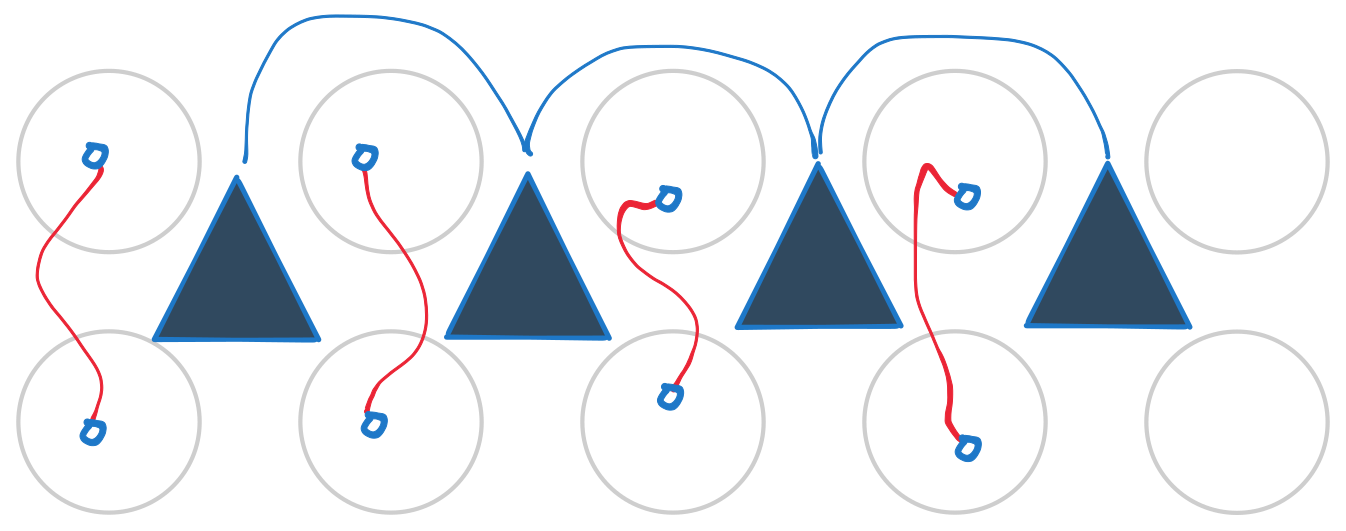

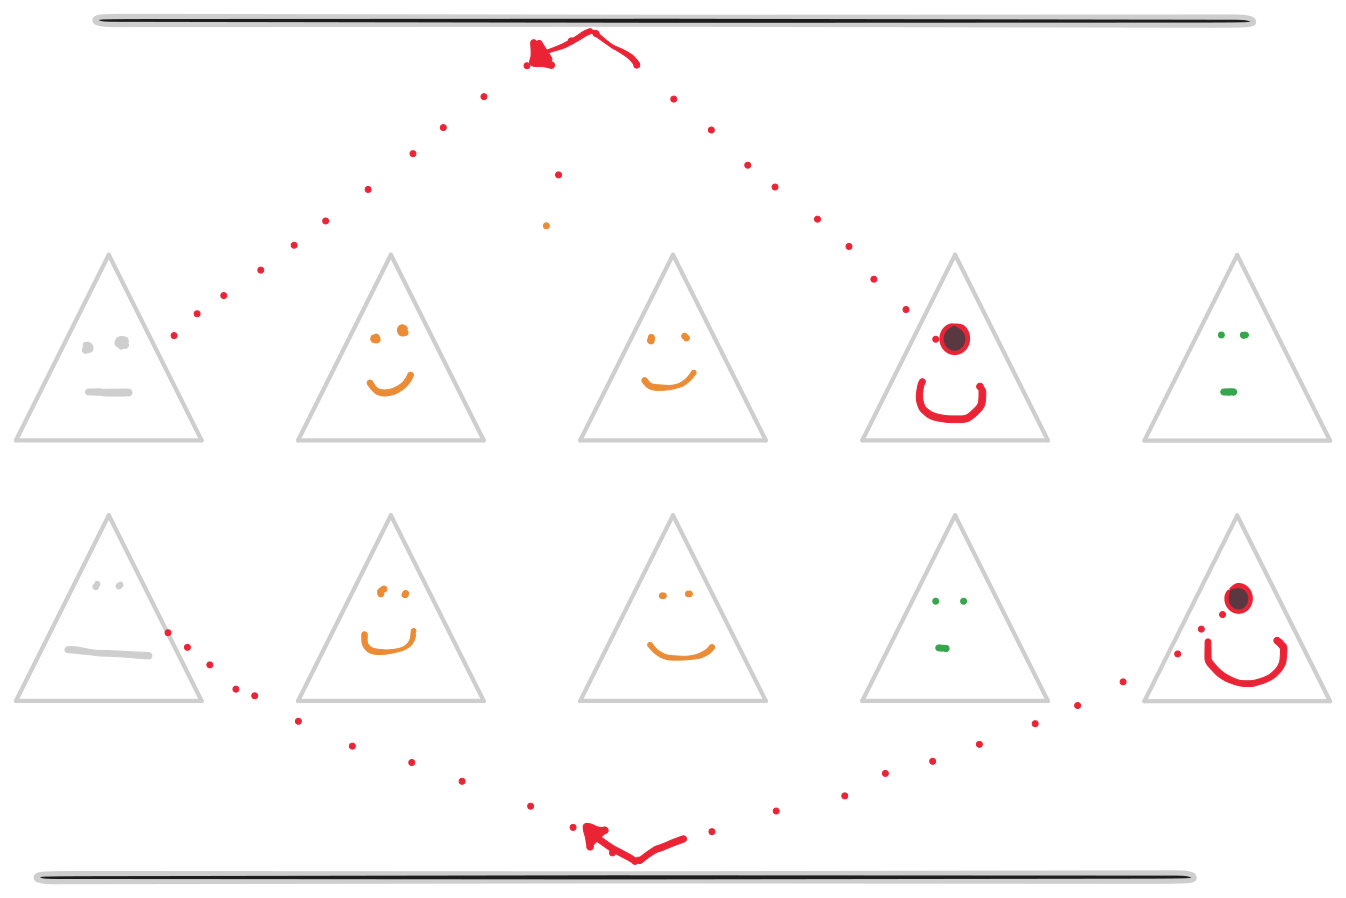

<IPython.core.display.SVG object>

<IPython.core.display.SVG object>

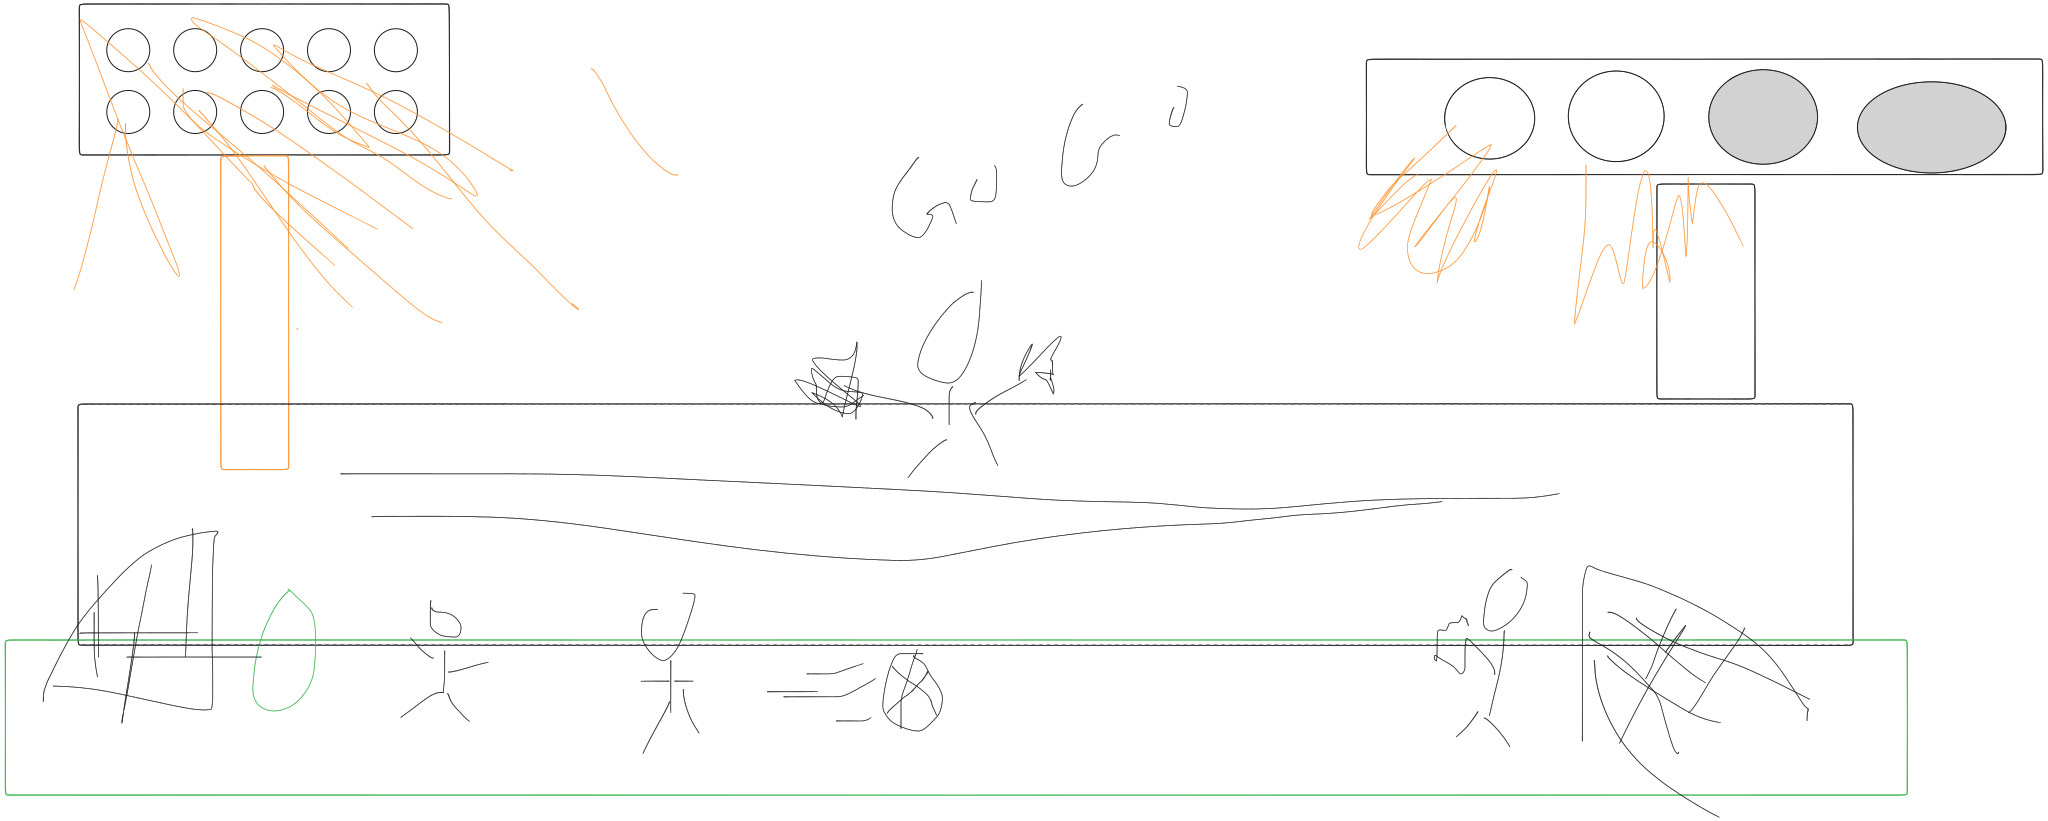

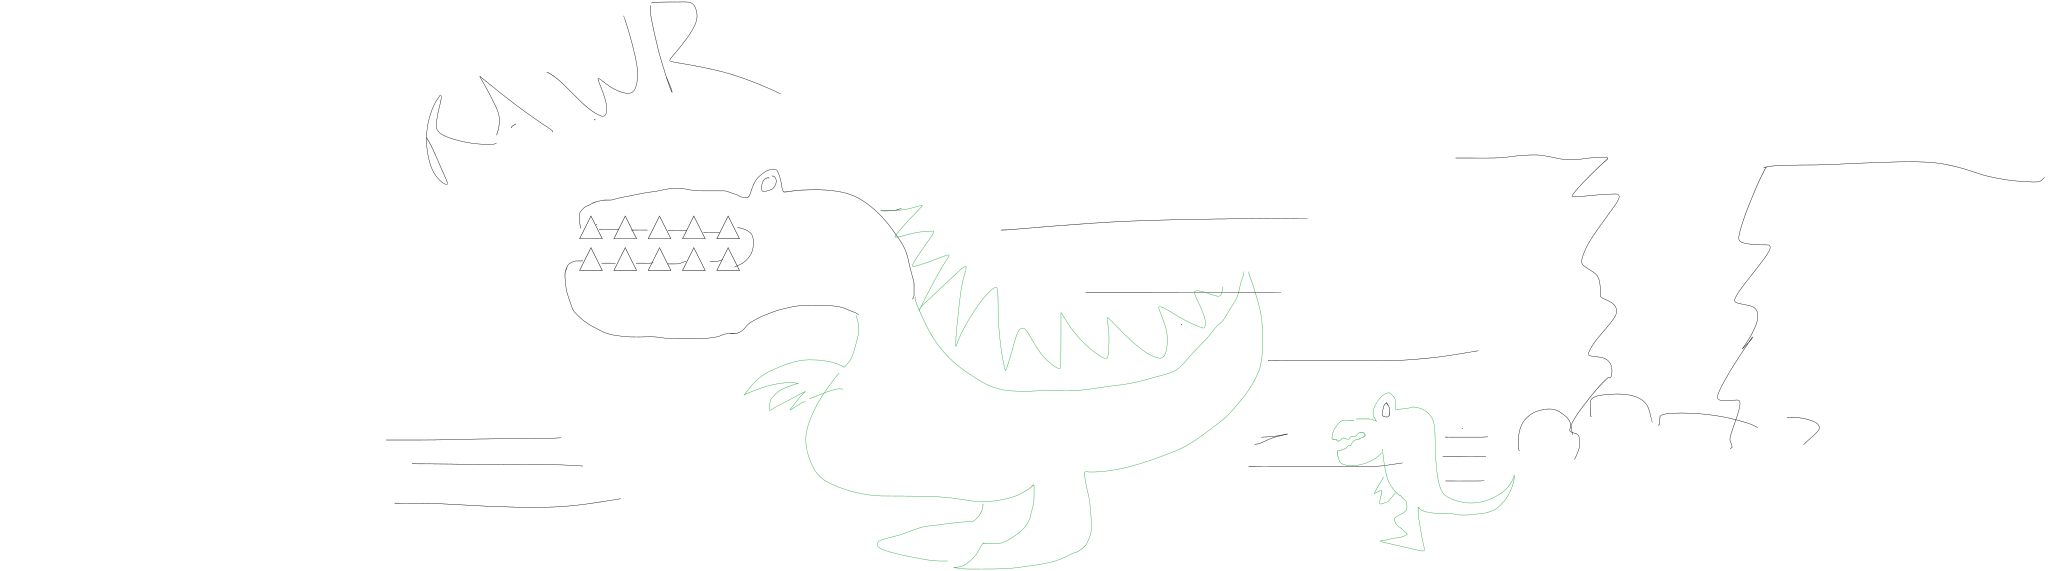

In [30]:
for i, row in drawings.iterrows():
    display(SVG(row['SVG']))

In [ ]:
unusual_uses = df[df['task'] == 'DivergentTest'].copy()

# unusual_uses.fillna({'menu':'baseline'}, inplace=True)

new_dfs = []

for index, row in unusual_uses.iterrows():
    for log in row['logs']:
        if log['type'] == 'DivergentTest':
#             print(row[['participant_id', 'menu', 'object']])
#             new_df = pd.DataFrame(log['values'], columns=['values'])
#             new_df = new_df.merge(pd.DataFrame(row), how='cross')
            rows = []
            for i, value in enumerate(log['values']):
                new_row = row.copy()
                new_row['topTwo'] = False if i >= len(log['topTwo']) or log['topTwo'][i] == None else log['topTwo'][i]
                new_row['value'] = value
                rows.append(new_row)
        
            
#             print(rows)

            # TODO: just need to pad the Nones with some falses to make things worlk
#             new_df.loc[list(map(bool, log['topTwo'])) + [False] * (len(log['values']) - len(log['topTwo'])), 'topTwo'] = True
            new_dfs.append(pd.DataFrame(rows))
            break
unusual_uses = pd.concat(new_dfs)
# def extract_unusual_uses(g):
#     for index, row in g.iterrows():
#         if not isinstance(row['logs'], list):
#             return pd.Series(pd.NA)

#         for log in row['logs']:
#             if log['type'] == 'DivergentTest':
#                 new_df = pd.DataFrame(log['values'], columns=['values'])
#                 new_df['topTwo'] = False
                
#                 # TODO: just need to pad the Nones with some falses to make things worlk
#                 new_df.loc[list(map(bool, log['topTwo'])) + [False] * (len(log['values']) - len(log['topTwo'])), 'topTwo'] = True
#                 return new_df
        
# unusual_uses = unusual_uses.groupby(['participant_id', 'menu', 'object']).apply(extract_unusual_uses).reset_index()
# del unusual_uses['level_3']
# del unusual_uses[0]

In [ ]:
counts = unusual_uses.groupby(['participant_id', 'menu']).count()
# assert len(counts[counts['value'] <= 2]) == 0
counts[counts['value'] < 2]
# counts

In [ ]:
unusual_uses[unusual_uses['topTwo']].to_csv('./toptwo.csv', index=False)
display(FileLink('./toptwo.csv'))
unusual_uses[unusual_uses['topTwo']]

In [ ]:
unusual_counts = unusual_uses.groupby(['participant_id','menu', 'object']).count().reset_index()

In [ ]:
sns.catplot(data=unusual_counts, kind="bar", x='object', y='value')

In [ ]:
sns.catplot(data=unusual_counts, kind="bar", x='menu', y='value')

In [ ]:
unusual_uses.groupby(['participant_id','menu']).count()

In [ ]:
unusual_uses.groupby(['menu','object']).count()

In [ ]:
from collections import defaultdict

participants = defaultdict(lambda: defaultdict(lambda: {'Keyboard Shortcuts' : 0, 'Marking Menu' : 0,'Tool Palette' :0, 'Baseline' : 0}))
for index,row in unusual_counts.iterrows():
    participants[row['participant_id']][row['menu']] = row['value']
    
for participant, counts in participants.items():
    for menu, count in counts.items():
        if count < 2:
            print(participant, menu, count)

In [ ]:
tlx = df[df['task'] == 'NasaTlx']


def extract_tlx(row):
    if not isinstance(row['logs'], list):
        return pd.Series(pd.NA)
    
    for log in row['logs']:
        if log['type'] == 'NasaTlx':
            return pd.Series(log['responses'])
tlx = pd.concat([tlx, tlx.apply(extract_tlx, axis=1)], axis=1)

metrics = 'Mental Demand	Physical Demand	Temporal Demand	Performance	Effort	Frustration'.split('	')

melted_tlx = pd.melt(tlx, id_vars=list(set(tlx.columns) - set(metrics)), value_vars=metrics)

In [ ]:
sns.catplot(data=melted_tlx, kind="bar", x='menu', y='value', col="variable", col_wrap=3)

In [ ]:
questionnaire = df[df['task'] == 'Questionnaire']

def extract_questionnaire(row):
    if not isinstance(row['logs'], list):
        return pd.Series(pd.NA)

    for log in row['logs']:
        if log['type'] == 'QuestionnaireResponses':
            return pd.Series(log['responses'])
        
questionnaire = pd.concat([questionnaire, questionnaire.apply(extract_questionnaire, axis=1)], axis=1)
# questionnaire['felt'] = questionnaire['I felt creative while I was selecting commands.']
# questionnaire['use'] = questionnaire['I would like to use that command selection technique while doing a creative task like drawing or writing a story.']



In [ ]:
questionnaire[questionnaire['felt'].isna()]

## I felt creative while I was selecting commands.

In [ ]:
sns.catplot(data=questionnaire, kind="bar", x='menu', y='felt')

In [ ]:
stats.friedmanchisquare(questionnaire[questionnaire['menu'] == 'Marking Menu']['felt'], 
                        questionnaire[questionnaire['menu'] == 'Tool Palette']['felt'], 
                        questionnaire[questionnaire['menu'] == 'Keyboard Shortcuts']['felt'])

## I would like to use that command selection technique while doing a creative task like drawing or writing a story.

In [ ]:
sns.catplot(data=questionnaire, kind="bar", x='menu', y='imagine')

In [ ]:
stats.friedmanchisquare(questionnaire[questionnaire['menu'] == 'Marking Menu']['imagine'], 
                        questionnaire[questionnaire['menu'] == 'Tool Palette']['imagine'], 
                        questionnaire[questionnaire['menu'] == 'Keyboard Shortcuts']['imagine'])

In [ ]:
comments = df[df['task'] == 'AdditionalComments'].copy()

def find_log(logs):
    for log in logs:
        if log['type'] == 'COMMENTS':
            return log['data']
        
comments['comments'] = comments['logs'].map(find_log)


comments.style.set_properties(subset=['comments'], **{'width': '800px'})
comments[['comments']]


In [ ]:
mouse_positioning = df[df['task'] == 'MousePositioning'].copy()

def extract_selection(row):
    errors = 0
    start = None
    end = None
    for log in row['logs']:
        if log['type'] == 'WRONG_COMMAND':
            errors += 1
        if log['type'] == 'START':
            start = log['timestamp']
        if log['type'] == 'END':
            end = log['timestamp']
    row['errors'] = errors
    row['has_error'] = errors > 0
    row['duration_milliseconds'] = end - start
    row['duration_minutes'] = row['duration_milliseconds'] / 1000 / 60
    return row

mouse_positioning['trial'] = mouse_positioning['__INDEX__'].map(lambda x: x[2])
mouse_positioning['trial_total'] = mouse_positioning['__INDEX__'].map(lambda x: x[0] * x[1])

mouse_positioning = mouse_positioning[['participant_id', '__INDEX__', 'logs', 'command', 'trial','trial_total', 'menu']]

mouse_positioning = mouse_positioning.apply(extract_selection, axis=1)
mouse_positioning['menu'] = mouse_positioning.menu.astype("category")

In [ ]:
sns.catplot(data=mouse_positioning, kind="bar", x='menu', y='duration_milliseconds')

In [ ]:
sns.catplot(data=mouse_positioning.groupby(['participant_id','menu']).sum().reset_index(), kind="bar", x='menu', y='duration_minutes')

In [ ]:
sns.catplot(data=mouse_positioning, kind="bar", hue="menu", x='participant_id', y='duration_milliseconds', height=5, aspect=15/5)

In [ ]:
sns.catplot(data=mouse_positioning, kind="bar", x='participant_id', y='duration_milliseconds', row='menu', height=5, aspect=15/5)

In [ ]:
sns.catplot(data=mouse_positioning, kind="bar", x='trial', y='duration_milliseconds', row='menu', height=5, aspect=15/5)

In [ ]:
sns.relplot(data=mouse_positioning,kind='line', x='trial', y='duration_milliseconds', hue="menu", height=5, aspect=15/5)

In [ ]:
sns.relplot(data=mouse_positioning, kind="line", x='trial', y='duration_milliseconds', row='menu', hue='participant_id', height=5, aspect=15/5)